## Extra credit assignment

In this homework, you will use two data sets: NYC restaurant inspections and 311 complaints. NYC DOHMH conducts inspections for all restaurants in the city on regular basis and report or take suitable action against the concerned restaurant. You'll use features from the restaurant violations and will check how well these are to predict the 311 complaint types regarding restaurants. You will also use clustering to check which areas are similar in terms of restaurant violations. 

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

### Download restaurant inspections data

other method is to manually download from the website: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [2]:
## read the data

data = pd.read_csv('https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD', 
                   parse_dates=['INSPECTION DATE'])
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point
0,50127646,INDAY,Brooklyn,658,DRIGGS AVENUE,11211.0,3475727699,NaN,1900-01-01,NaN,...,NaN,40.714656,-73.959000,301.0,34.0,55300.0,3000000.0,3.023660e+09,BK73,NaN
1,50127773,MAMAN,Manhattan,155,EAST 44 STREET,10017.0,7184507160,NaN,1900-01-01,NaN,...,NaN,40.752379,-73.974240,106.0,4.0,9200.0,1036177.0,1.012990e+09,MN19,NaN
2,50128839,LA STEAK RESTAURANT AND BAR,Queens,1511A,COLLEGE POINT BLVD,11356.0,3474007122,NaN,1900-01-01,NaN,...,NaN,40.784035,-73.845805,407.0,19.0,92500.0,4098329.0,4.040840e+09,QN23,NaN
3,50112274,NaN,Bronx,4005,EAST TREMONT AVENUE,10465.0,9175744768,NaN,1900-01-01,NaN,...,NaN,40.820252,-73.817941,210.0,13.0,13000.0,2077284.0,2.054450e+09,BX52,NaN
4,50126573,NaN,Manhattan,42 W,42ND ST,10036.0,7187901106,NaN,1900-01-01,NaN,...,NaN,40.754068,-73.982321,105.0,4.0,8400.0,1085593.0,1.012570e+09,MN17,NaN


In [3]:
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point'],
      dtype='object')

You only need certain columns for the tasks, namely 'CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude'

'CAMIS' is a unique identifier for a restaurant/business. 'INSPECTION DATE' is the date on which inspection took place. 'ACTION' tells what kind of action was taken, 'VIOLATION DESCRIPTION' is the type of violation reported.

'SCORE' is the measure of severity of violations reported. A higher score means the restaurant had more violations/bad violations. 

'GRADE' is also a measure of restaurant violations. The best grade is 'A' (which means restaurant had minor/no violations), followed by 'B' and 'C', which mean more serious violations. 'P' grade means the inspection is pending and 'N' and 'Z' mean grades was not assigned due to some reasons.

In [4]:
## keep only the above columns
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point'],
      dtype='object')

In [5]:
## keep only the above columns
columns=[ 'CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude']
data = data[columns]


### Keep data only for 2019

In [6]:
data=data[pd.DatetimeIndex(data['INSPECTION DATE']).year==2019]
data.head()

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
14,41307383,11206.0,2019-07-19,No violations were recorded at the time of thi...,NaN,0.0,NaN,40.705026,-73.933229
16,41721168,10458.0,2019-08-26,No violations were recorded at the time of thi...,NaN,NaN,NaN,40.861846,-73.891705
17,50011205,11354.0,2019-11-20,No violations were recorded at the time of thi...,NaN,NaN,NaN,40.758824,-73.831822
27,41539993,11220.0,2019-12-09,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,42.0,NaN,40.638764,-74.006136
88,40825908,NaN,2019-11-13,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,32.0,C,0.000000,0.000000


### Remove rows where the 'ACTION' was restaurant closure: 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.' and 'Establishment re-closed by DOHMH'

In [7]:
data["ACTION"].value_counts()

Violations were cited in the following area(s).                                                                                       58920
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.     2312
Establishment re-opened by DOHMH.                                                                                                       753
No violations were recorded at the time of this inspection.                                                                             554
Name: ACTION, dtype: int64

In [8]:
data=data[data["ACTION"]!='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.']

### You only need certain type of violations for further analysis. Keep only the rows where 'VIOLATION DESCRIPTION' was one of the below categories

In [9]:
violCat = pd.read_csv('https://raw.githubusercontent.com/CUSP2020PUI/Data/master/RestViol_types.csv')
violCat.head()

,VIOLATION DESCRIPTION,count
0,Facility not vermin proof. Harborage or condit...,41352
1,Evidence of mice or live mice present in facil...,27816
2,"Food contact surface not properly washed, rins...",25889
3,Food not protected from potential source of co...,25336
4,Cold food item held above 41Âº F (smoked fish ...,22834


In [10]:
# keep rows just for above categories

data = data[data['VIOLATION DESCRIPTION'].isin(violCat['VIOLATION DESCRIPTION'])]
data.shape

(26864, 9)

### Filter out GRADES that are 'P', 'N' and 'Z'

Do not remove the NaN values from 'GRADE' yet

In [11]:
data.GRADE.unique()

array(['A', nan, 'B', 'P', 'C', 'N', 'Z'], dtype=object)

In [12]:
data.shape

(26864, 9)

In [13]:
data=data[~data["GRADE"].isin(["P","N","Z"])]

In [14]:
print(data.shape)

(26531, 9)


Zip codes shapefile

In [15]:
# or use this
urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')
    
zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


### Merge the violations data with zip code shapefile on column 'ZIPCODE'

In [16]:
df_merge=pd.merge(data,zips,on="ZIPCODE")
df_merge.shape

(27139, 11)

### Next, you need to aggregare features by zipcode. You need to get number of violations, average score, and ratio of each grade 'A', 'B' and 'C'. The ratio for a particular grade 'A' should be calculated as number of inspections when restaurants were graded 'A' divided by total number of inspections. In the end, you should have 5 above featues for each zip code.

In [17]:
# get number of violations and average score
df_zips=df_merge.groupby(["ZIPCODE"]).agg({"ACTION":'count',"SCORE":"mean"})
df_zips.columns=['violations','avg_score']
df_zips.head()


,violations,avg_score
ZIPCODE,,
10001.0,403,20.724566
10002.0,566,21.123894
10003.0,697,18.395983
10004.0,588,24.156463
10005.0,32,21.500000


In [18]:
## get each grade ratio per zip code

grade=pd.pivot_table(df_merge[['ZIPCODE','GRADE','INSPECTION DATE']], index='ZIPCODE', columns=["GRADE"], aggfunc='count')
grade.columns = ["A","B","C"]
for i in grade.columns:
    grade[i] = grade[i]/df_merge.groupby('ZIPCODE').size()*100 
grade.head()

,A,B,C
ZIPCODE,,,
10001.0,43.672457,6.699752,2.481390
10002.0,33.568905,10.424028,0.706714
10003.0,44.476327,7.604017,3.012912
10004.0,38.775510,2.721088,7.482993
10005.0,43.750000,9.375000,6.250000


In [19]:
## merge number of violations, avg score and grade ratios 
Total_merge=pd.merge(df_zips,grade,left_index=True,right_index=True)


In [20]:
Total_merge.head()

,violations,avg_score,A,B,C
ZIPCODE,,,,,
10001.0,403,20.724566,43.672457,6.699752,2.481390
10002.0,566,21.123894,33.568905,10.424028,0.706714
10003.0,697,18.395983,44.476327,7.604017,3.012912
10004.0,588,24.156463,38.775510,2.721088,7.482993
10005.0,32,21.500000,43.750000,9.375000,6.250000


In [21]:
Total_merge.shape

(201, 5)

### Read 311 data.

This data containts all restaurant related complaints for 2019. 'Unique Key' is a unique identifier for each complaint

In [22]:
data311 = pd.read_csv('https://raw.githubusercontent.com/CUSP2020PUI/Data/master/311_foodComplaints.csv')
data311.head()

,Unique Key,Incident Zip,Complaint Type,Descriptor
0,34057077,10020.0,Food Establishment,Dishwashing/Utensils
1,34057113,11104.0,Food Poisoning,1 or 2
2,34057299,10027.0,Food Establishment,Rodents/Insects/Garbage
3,34057325,10017.0,Food Establishment,Bare Hands in Contact w/ Food
4,34057330,11385.0,Food Establishment,Bare Hands in Contact w/ Food


In [23]:
data311.shape

(22388, 4)

### Group these 311 complaints by zip code

In [24]:
df_311_zip=data311.groupby("Incident Zip").agg({"Unique Key":"count"})

In [25]:
df_311_zip.columns=["Complaints"]
df_311_zip=df_311_zip.reset_index()
df_311_zip.head()

,Incident Zip,Complaints
0,0.0,1
1,83.0,1
2,10000.0,2
3,10001.0,331
4,10002.0,348


In [26]:
merge_zips=pd.merge(zips,df_311_zip,left_on="ZIPCODE",right_on="Incident Zip")
merge_zips=merge_zips.drop(columns=["Incident Zip"])
merge_zips["Norm_Comp"]=merge_zips["Complaints"]/merge_zips["POPULATION"]*1000 
merge_zips.head()

,ZIPCODE,POPULATION,geometry,Complaints,Norm_Comp
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",24,1.284728
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",118,1.890238
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",151,1.800491
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",119,2.105189
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",145,2.006087


In [27]:
merge_zips=merge_zips.reset_index()
df_merger=pd.merge(Total_merge,merge_zips,on="ZIPCODE")
df_merger.head()


,ZIPCODE,violations,avg_score,A,B,C,index,POPULATION,geometry,Complaints,Norm_Comp
0,10001.0,403,20.724566,43.672457,6.699752,2.481390,82,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",331,14.768215
1,10002.0,566,21.123894,33.568905,10.424028,0.706714,92,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",348,4.280180
2,10003.0,697,18.395983,44.476327,7.604017,3.012912,90,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",505,9.037546
3,10004.0,588,24.156463,38.775510,2.721088,7.482993,105,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",75,34.293553
4,10004.0,588,24.156463,38.775510,2.721088,7.482993,106,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",75,34.293553


In [37]:
df_merger.drop(columns ='index', axis=1, inplace = True)
df_merger.head()



,ZIPCODE,violations,avg_score,A,B,C,POPULATION,geometry,Complaints,Norm_Comp
0,10001.0,403,20.724566,43.672457,6.699752,2.481390,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",331,14.768215
1,10002.0,566,21.123894,33.568905,10.424028,0.706714,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",348,4.280180
2,10003.0,697,18.395983,44.476327,7.604017,3.012912,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",505,9.037546
3,10004.0,588,24.156463,38.775510,2.721088,7.482993,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",75,34.293553
4,10004.0,588,24.156463,38.775510,2.721088,7.482993,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",75,34.293553


### Normalize the number of 311 complaints and number of violations by population (per 1000 people)

In [38]:
df_merger["Violations_Norm"]=df_merger["violations"]/df_merger["POPULATION"]*1000
df_merger.head()

,ZIPCODE,violations,avg_score,A,B,C,POPULATION,geometry,Complaints,Norm_Comp,Violations_Norm
0,10001.0,403,20.724566,43.672457,6.699752,2.481390,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",331,14.768215,17.980636
1,10002.0,566,21.123894,33.568905,10.424028,0.706714,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",348,4.280180,6.961441
2,10003.0,697,18.395983,44.476327,7.604017,3.012912,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",505,9.037546,12.473603
3,10004.0,588,24.156463,38.775510,2.721088,7.482993,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",75,34.293553,268.861454
4,10004.0,588,24.156463,38.775510,2.721088,7.482993,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",75,34.293553,268.861454


In [39]:
# check statistics of all features
df_merger.describe()

,ZIPCODE,violations,avg_score,A,B,C,POPULATION,Complaints,Norm_Comp,Violations_Norm
count,210.000000,210.000000,210.000000,209.000000,163.000000,113.000000,210.000000,210.000000,210.000000,210.000000
mean,10766.300000,144.204762,18.843029,47.262478,9.077441,5.007975,39974.609524,110.057143,inf,inf
std,588.391645,144.652003,4.022133,16.491169,5.809753,4.879264,28264.229414,98.610231,NaN,NaN
min,10001.000000,1.000000,5.000000,15.555556,1.587302,0.325733,0.000000,1.000000,0.170940,0.257268
25%,10121.500000,43.250000,17.188005,37.500000,5.142857,2.352941,18146.250000,35.250000,1.486496,1.548295
50%,11002.500000,100.500000,19.241358,43.624161,7.971014,3.802281,37186.000000,86.000000,2.475369,2.700089
75%,11357.750000,178.000000,21.075847,51.456311,11.924171,5.952381,58610.500000,149.750000,4.654521,6.739967
max,11697.000000,697.000000,33.458333,100.000000,42.857143,29.787234,109069.000000,505.000000,inf,inf


In [40]:
## keep only rows where normalized 311 complaints (per 1000 people) are <30
df_merger=df_merger[df_merger["Norm_Comp"]<30]
df_merger.head()

,ZIPCODE,violations,avg_score,A,B,C,POPULATION,geometry,Complaints,Norm_Comp,Violations_Norm
0,10001.0,403,20.724566,43.672457,6.699752,2.481390,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",331,14.768215,17.980636
1,10002.0,566,21.123894,33.568905,10.424028,0.706714,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",348,4.280180,6.961441
2,10003.0,697,18.395983,44.476327,7.604017,3.012912,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",505,9.037546,12.473603
7,10005.0,32,21.500000,43.750000,9.375000,6.250000,8107.0,"POLYGON ((982595.679 195880.754, 982587.366 19...",55,6.784261,3.947206
8,10006.0,43,19.813953,46.511628,NaN,NaN,3011.0,"POLYGON ((981136.343 198082.384, 981481.097 19...",37,12.288276,14.280970


### Visualization

Plot normalized number of violations, average score and normalized 311 complaints on separate maps 

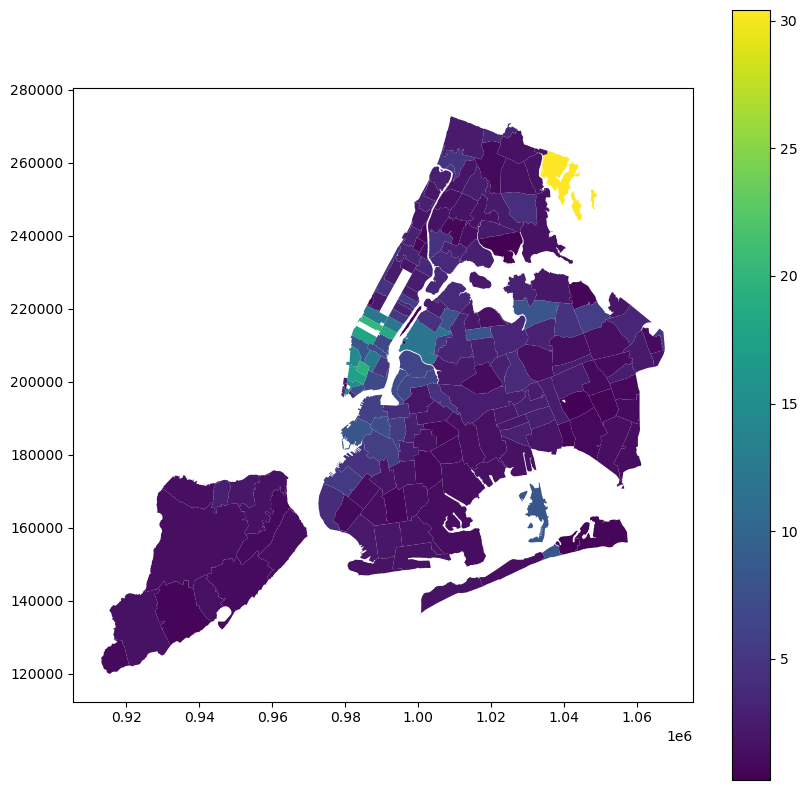

In [41]:
## normalized number of violations (per 1000 people)
zips_gpd = gpd.GeoDataFrame(df_merger.fillna(0), geometry='geometry')
zips_gpd.plot(figsize=(10,10), column='Violations_Norm', legend=True)
plt.show()

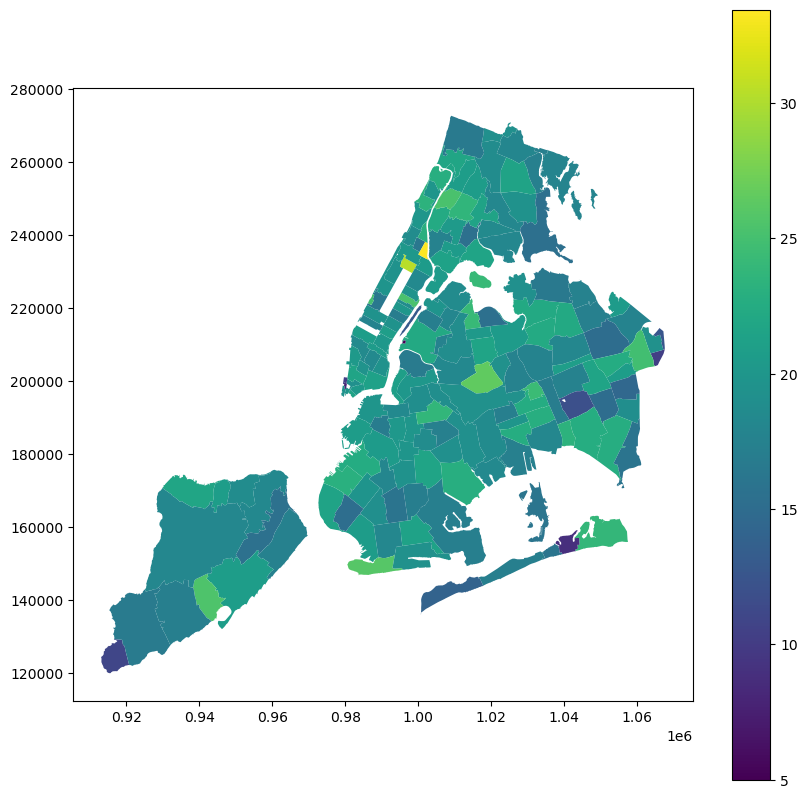

In [42]:
## average score
zips_gpd.plot(figsize=(10,10), column='avg_score', legend=True)
plt.show()

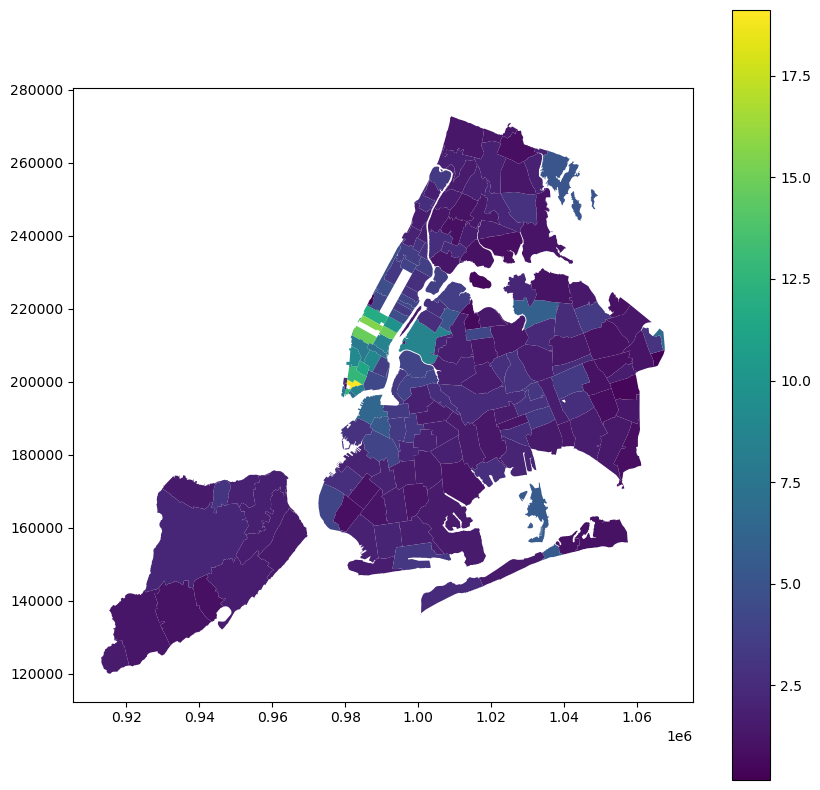

In [43]:
## normalized 311 complaints (per 1000 people)
zips_gpd.plot(figsize=(10,10), column='Norm_Comp', legend=True)
plt.show()

### Perform clustering analyses by assigning each zipcode to a cluster. Use K-means clustering and choose appropriate number of clusters with average silhouette score and visualize the clusters on the map.

Take only the following features: normalized number of violations, average score and ratios for each grade for the task

These features make an approximate profile of a neighborhood in terms of the quality and performance of restaurants and food businesses present there. With clustering, we would get an idea about what areas have similar profiles and would help understand the areas where restaurants behave similarly. 

Make sure to standardize the data before clustering

In [44]:
## perform clustring analyses
columns=['avg_score', 'A', 'B', 'C','Violations_Norm']
cluster=zips_gpd[columns]
## use average silhouette score (just report the scores and choose best for number of clusters to be used)
## try with (3-15 clusters)


In [45]:
cluster=(cluster-np.mean(cluster))/np.std(cluster)

In [47]:
for n_clusters in range(3,16): 
    km = KMeans(n_clusters=n_clusters, random_state=999)
    cluster_labels = km.fit_predict(cluster)
    silhouette_avg = silhouette_score(cluster, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =3, the average silhouette_score is :0.25882733397193775
For n_clusters =4, the average silhouette_score is :0.26886501688878045
For n_clusters =5, the average silhouette_score is :0.2723533171112612
For n_clusters =6, the average silhouette_score is :0.26675528585648406
For n_clusters =7, the average silhouette_score is :0.25069472621767996
For n_clusters =8, the average silhouette_score is :0.2549496488716146
For n_clusters =9, the average silhouette_score is :0.23943591135847928
For n_clusters =10, the average silhouette_score is :0.24650817514143636
For n_clusters =11, the average silhouette_score is :0.262815389671667
For n_clusters =12, the average silhouette_score is :0.2582824842582907
For n_clusters =13, the average silhouette_score is :0.24404988686926704
For n_clusters =14, the average silhouette_score is :0.25255077373805934
For n_clusters =15, the average silhouette_score is :0.2624358540562887


In [48]:
## plot all clustered zips in the map
n = 5
km = KMeans(n_clusters=n, random_state=324)
cluster_labels = km.fit_predict(cluster)
zips_gpd['Cluster Labels'] = cluster_labels
zips_gpd['Cluster Labels'] = zips_gpd['Cluster Labels'].astype(str)

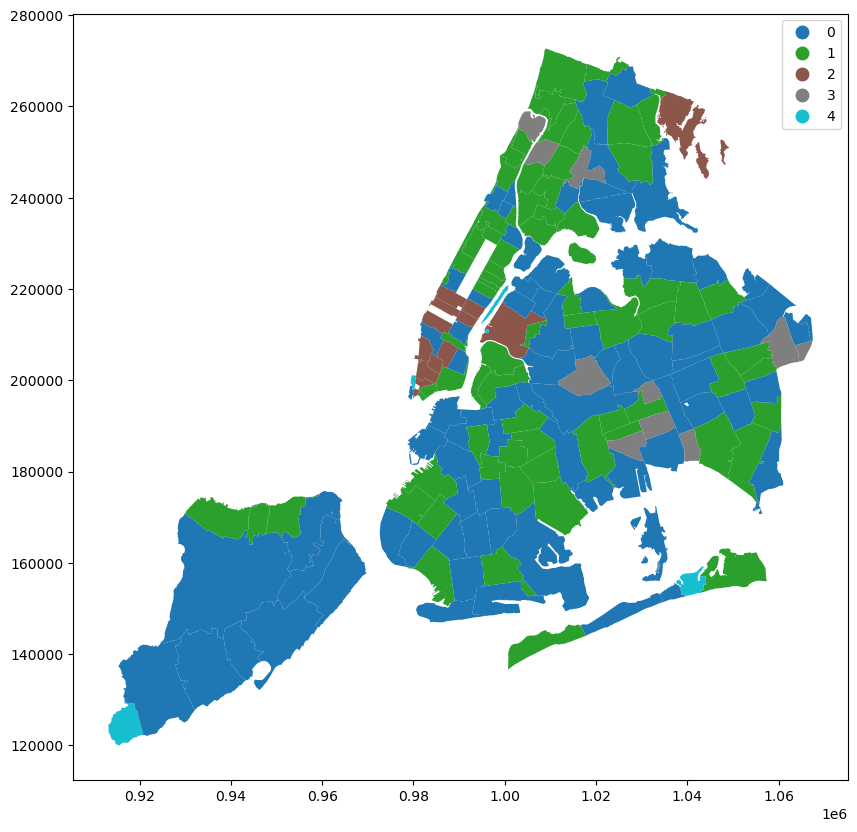

In [49]:
zips_gpd.plot(figsize=(10,10), column='Cluster Labels', legend=True)
plt.show()

### Perform a regression analyses with normalized 311 complaints as the target and above features (normalized number of violations, average score, and ratios of 'A', 'B' and 'C' grades) as regressors. Comment on the signficance of each feature.

Include the intercept for the regression analysis. Try performing regression with each of the regressors individually (with normalized 311 complaints as target). Comment on how these regressor perform against each other. What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.

In [51]:
M=[]
for i in columns:
    lm=smf.ols(formula='Norm_Comp~'+i, data = zips_gpd).fit()
    R2=lm.rsquared
    coeff=lm.params[i]
    p_coeff=lm.pvalues[i]
    M.append([i,R2,coeff,p_coeff])
    
df=pd.DataFrame(M,columns=["Regressor","R2","Coefficient","P_value-Coefficient"])
df.head()

,Regressor,R2,Coefficient,P_value-Coefficient
0,avg_score,0.001791,0.036576,5.641459e-01
1,A,0.000714,0.006134,7.158059e-01
2,B,0.006713,-0.038814,2.636400e-01
3,C,0.009034,-0.063683,1.944632e-01
4,Violations_Norm,0.536527,0.435788,6.919378e-33
